# Testing saddle point problems in package `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using Compat
using Compat: range

First create a grid and a Laplacian operator on it

In [4]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [5]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid with spacing 1.0

Now create a shape, with discrete points and associated regularization and interpolation operator

In [6]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ)
yb = 1.0 .+ R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

In [7]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

In [8]:
PS = SaddleSystem((w,f),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 128 constraints and
   State of type Nodes{Dual,130,130}
   Force of type ScalarData{128}


  0.034739 seconds (135 allocations: 1.183 MiB)


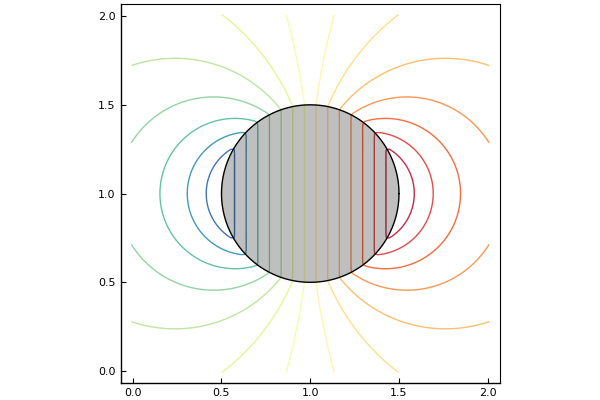

In [9]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PS\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [10]:
using LinearAlgebra

In [11]:
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.03528802363993222

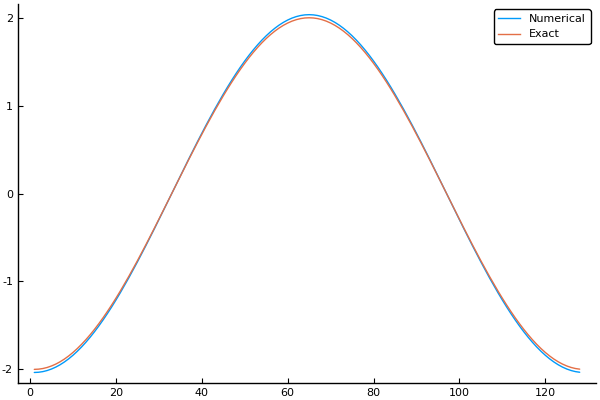

In [12]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

#### Now try storing the Schur matrix

In [13]:
PSstore = SaddleSystem((w,f),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true,store=true)

Saddle system with 128 constraints and
   State of type Nodes{Dual,130,130}
   Force of type ScalarData{128}


This way is significantly faster

  0.016615 seconds (41 allocations: 668.109 KiB)


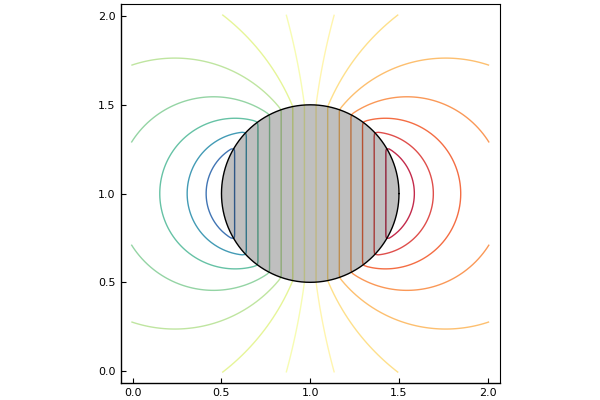

In [14]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PSstore\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

But there is significantly more noise in the force

In [15]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.15313453815091904

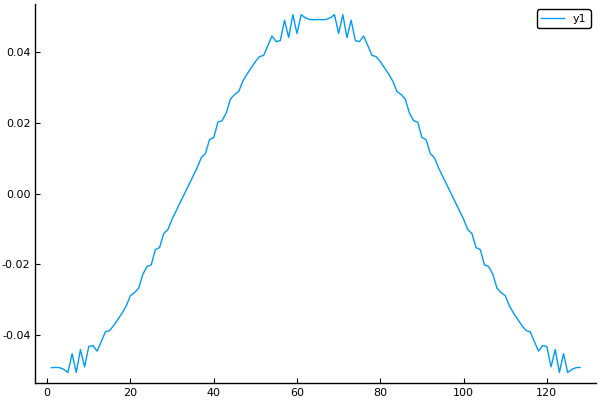

In [16]:
plot(f)

So let's filter it

In [17]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,f,w);
Ẽmat = InterpolationMatrix(Ẽ,w,f);

In [18]:
f̃ = ScalarData(X);

In [19]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f̃),(x->L\x,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P,store=true)

Saddle system with 128 constraints and
   State of type Nodes{Dual,130,130}
   Force of type ScalarData{128}


  0.017232 seconds (46 allocations: 800.297 KiB)


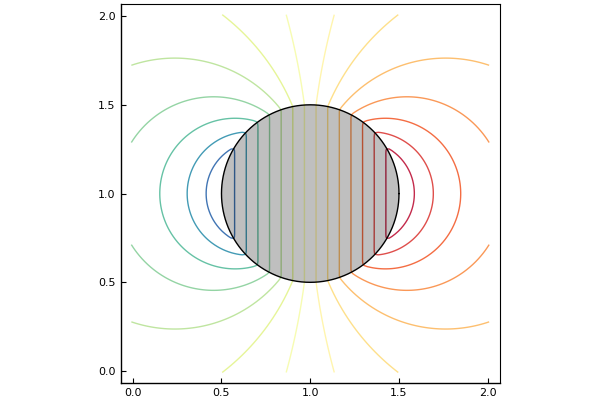

In [20]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [21]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.1034944566286875

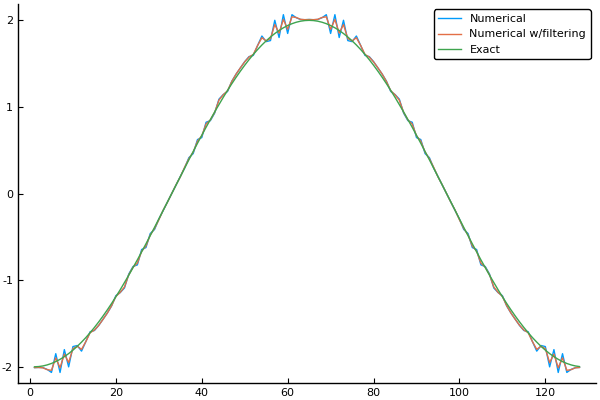

In [22]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

#### Test with the integrating factor as the operator, rather than Laplacian

In [23]:
Δt = 1.0
HS = SaddleSystem((w,f),(plan_intfact(Δt,w),Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 128 constraints and
   State of type Nodes{Dual,130,130}
   Force of type ScalarData{128}


In [24]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1).*(yb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = HS\(w,ψb)

  0.059462 seconds (199 allocations: 2.750 MiB)


(Dual nodes in a (nx = 130, ny = 130) cell grid
  Number of Dual nodes: (nx = 130, ny = 130), [8.90365e-16, 0.0772821, 0.14577, 0.22098, 0.316063, 0.318697, 0.482494, 0.433887, 0.601089, 0.567653  …  -0.637225, -0.567653, -0.601089, -0.433887, -0.482494, -0.318697, -0.316063, -0.22098, -0.14577, -0.0772821])

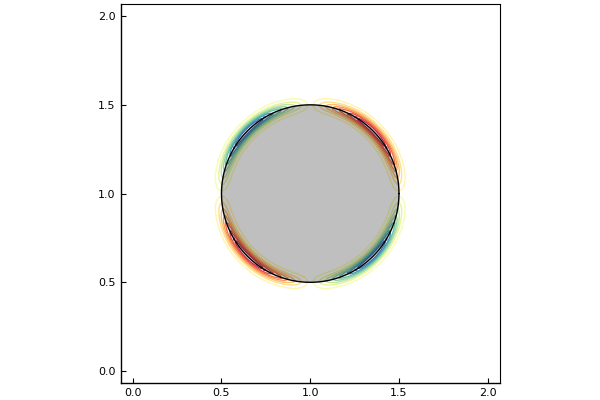

In [25]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

### Using saddle point solver on unconstrained problem

In [26]:
u = ones(Float64,2)
f = Vector{Float64}()
A⁻¹(u::Vector{Float64}) = u
B₁ᵀ(f::Vector{Float64}) = zeros(Float64,2)
B₂(u::Vector{Float64}) = Vector{Float64}()
sys = SaddleSystem((u,f),(A⁻¹,B₁ᵀ,B₂))

Saddle system with 0 constraints and
   State of type Array{Float64,1}
   Force of type Array{Float64,1}


In [27]:
sys\(u,f)

([1.0, 1.0], Float64[])

### Using saddle point solver on tuple of problems

In [28]:
ψb = ScalarData(X);
f = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);

In [29]:
u = ones(Float64,2)
f = Vector{Float64}()
A⁻¹(u::Vector{Float64}) = u
B₁ᵀ(f::Vector{Float64}) = zeros(Float64,2)
B₂(u::Vector{Float64}) = Vector{Float64}()
sys = SaddleSystem((u,f),(A⁻¹,B₁ᵀ,B₂))

Saddle system with 0 constraints and
   State of type Array{Float64,1}
   Force of type Array{Float64,1}


In [30]:
sysys = (PS,sys)
rhs = ((w,ψb),(u,f))
(ψ,f), (u,_) = sysys\rhs

((Dual nodes in a (nx = 130, ny = 130) cell grid
  Number of Dual nodes: (nx = 130, ny = 130), [-0.0494459, -0.0494575, -0.0495056, -0.0495389, -0.0491595, -0.0481594, -0.04797, -0.0468876, -0.0464229, -0.0449365  …  -0.0439177, -0.0449365, -0.0464229, -0.0468876, -0.04797, -0.0481594, -0.0491595, -0.0495389, -0.0495056, -0.0494575]), ([1.0, 1.0], Float64[]))